In [1]:
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme()
import regex as re 
import random
from collections import Counter
import pprint as pp
from see import see 
import nltk
# conda install -c conda-forge wordcloud
from wordcloud import WordCloud

In [2]:
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")

In [3]:
# read pickled DF from notebook #1 (initial exploratory data visuals)
df = pd.read_pickle('df_un_general_debates.pkl')

In [3]:
df.head()

,session,year,country,country_name,speaker,position,text,length
0,25,1970,ALB,Albania,Mr. NAS,NaN,33: May I first convey to our President the co...,51419
1,25,1970,ARG,Argentina,Mr. DE PABLO PARDO,NaN,177.\t : It is a fortunate coincidence that pr...,29286
2,25,1970,AUS,Australia,Mr. McMAHON,NaN,100.\t It is a pleasure for me to extend to y...,31839
3,25,1970,AUT,Austria,Mr. KIRCHSCHLAEGER,NaN,155.\t May I begin by expressing to Ambassado...,26616
4,25,1970,BEL,Belgium,Mr. HARMEL,NaN,"176. No doubt each of us, before coming up to ...",25911


In [4]:
# let's take a look at the first entry's full text 
df.text.iloc[0]

"33: May I first convey to our President the congratulations of the Albanian delegation on his election to the Presidency of the twenty-fifth session of the General Assembly?\n34.\tIn taking up the work on the agenda of the twenty- fifth session of the General Assembly, which is being held on the eve of the twenty-fifth anniversary of the coming into force of the Charter of the United Nations, the peace-loving Member States would have wished to be in a position to present on this occasion some picture of positive and satisfactory activity on the part of the United Nations. The Albanian delegation, for its part, would have taken great pleasure in drawing up such a balance sheet of activities covering a quarter of a century, which is certainly no short period in the life of an international organization. Unfortunately, this is not the situation. Created on the day after victory had been achieved over the Powers of the Rome BerlinTokyo Axis and conceived in the spirit of the principles wh

In [6]:
sample = df.text.iloc[0]

In [8]:
type(sample)

str

## Data Tokenisation with REGEX
#### Logic Flow Outline:
* Will use \p{L} to account for all unicode letters (accented letters like "â") - which are likely to be present in a corpus of this nature
    * This requires library regex over RE to work with posix 
* The following will match tokens consisting over at least one posix character class letters
    * Then followed or preceded by an arbitrary sequence of regular alpha-numeric characters (which includes underscores, hyphens, regular letters and digits etc.
* Will also convert all text to lowercase 

In [61]:
def tokenize_lowercase(text):
    return re.findall(r'[\w-]*\p{L}[\w-]*', text.lower())

In [39]:
tokens = tokenize_lowercase(sample)

In [23]:
print(tokens)

['may', 'i', 'first', 'convey', 'to', 'our', 'president', 'the', 'congratulations', 'of', 'the', 'albanian', 'delegation', 'on', 'his', 'election', 'to', 'the', 'presidency', 'of', 'the', 'twenty-fifth', 'session', 'of', 'the', 'general', 'assembly', 'in', 'taking', 'up', 'the', 'work', 'on', 'the', 'agenda', 'of', 'the', 'twenty-', 'fifth', 'session', 'of', 'the', 'general', 'assembly', 'which', 'is', 'being', 'held', 'on', 'the', 'eve', 'of', 'the', 'twenty-fifth', 'anniversary', 'of', 'the', 'coming', 'into', 'force', 'of', 'the', 'charter', 'of', 'the', 'united', 'nations', 'the', 'peace-loving', 'member', 'states', 'would', 'have', 'wished', 'to', 'be', 'in', 'a', 'position', 'to', 'present', 'on', 'this', 'occasion', 'some', 'picture', 'of', 'positive', 'and', 'satisfactory', 'activity', 'on', 'the', 'part', 'of', 'the', 'united', 'nations', 'the', 'albanian', 'delegation', 'for', 'its', 'part', 'would', 'have', 'taken', 'great', 'pleasure', 'in', 'drawing', 'up', 'such', 'a', 'b

In [65]:
## standard nltk corpus stop words 
## convert to set (has a near constant lookup time)
stopwords = set(nltk.corpus.stopwords.words('english'))

In [31]:
# E.G. of the types of words in the stopwords
random.sample(stopwords, 5)

C:\Users\jason\AppData\Local\Temp/ipykernel_16508/981306578.py:1: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  random.sample(stopwords, 5)


['not', 'and', 'whom', 'him', "doesn't"]

### IMPORTANT CONSIDERATION
* the inclusion of the word "not" / "do not" etc; means removing it might alter the result of some later sentiment analysis results
    * E.G. I do not like aggression  >> becomes >> I like aggression
    
* We can address this in a subsequent step 

In [ ]:
# try a first pass of adding some "classic" speech stopwords, based off our initial understanding of the corpus
## we can later tweek this to include other words from subsequent analysis like frequency % across documents etc.

In [66]:
# make sure to use lowercase 
additional_stopwords = {'dear','regards','also','would','must'}

In [67]:
# might have relevance in a corpus of this nature 
exclude_stopwords = {'against'}

In [68]:
# user set operators to add or remove these elements from our base collection
stopwords |= additional_stopwords

## use the set difference to remove these words 
stopwords -= exclude_stopwords 

In [69]:
## define a function to remove these stopwords from the text 
def remove_stopwords(tokens):
    return [t for t in tokens if t.lower() not in stopwords]

### Wrap these two functions into a pipeline to obtain a new column "tokens" with our cleaned data
* setting it up in this pipeline fashion makes it easy to come back and add or remove elements if we need to change something later 

In [70]:
pipeline = [tokenize_lowercase, remove_stopwords]

In [71]:
def prepare_text(text, pipeline):
    tokens = text
    
    for transform_element in pipeline:
        tokens = transform_element(tokens)
        
    return tokens 

In [22]:
# apply to our DF to acquire a new column of our now cleaned data
# note: progress_apply for tqdm bar 
df['tokens'] = df['text'].progress_apply(prepare_text, pipeline=pipeline)

progress-bar: 100%|███████████████████████████████████████████████████████████████| 7507/7507 [00:16<00:00, 448.53it/s]


In [23]:
# can also add a column which includes the new length of the tokens - could be useful later 
df['len_tokens'] = df['tokens'].map(len)

In [24]:
df.head()

,session,year,country,country_name,speaker,position,text,length,tokens,len_tokens
0,25,1970,ALB,Albania,Mr. NAS,NaN,33: May I first convey to our President the co...,51419,"[may, first, convey, president, congratulation...",4125
1,25,1970,ARG,Argentina,Mr. DE PABLO PARDO,NaN,177.\t : It is a fortunate coincidence that pr...,29286,"[fortunate, coincidence, precisely, time, unit...",2327
2,25,1970,AUS,Australia,Mr. McMAHON,NaN,100.\t It is a pleasure for me to extend to y...,31839,"[pleasure, extend, mr, president, warmest, con...",2545
3,25,1970,AUT,Austria,Mr. KIRCHSCHLAEGER,NaN,155.\t May I begin by expressing to Ambassado...,26616,"[may, begin, expressing, ambassador, hambro, b...",2135
4,25,1970,BEL,Belgium,Mr. HARMEL,NaN,"176. No doubt each of us, before coming up to ...",25911,"[doubt, us, coming, rostrum, wonders, usefulne...",2025


In [25]:
## count the most frequent words within the corpus (counter requires list as input hence tokenisation first is essential)
## this might help us update our stopwords etc. in future iterations 
counter = Counter()

# pass the update element of counter into the map function 
# pass _ to supress the non-sensical output 
_ = df['tokens'].map(counter.update)

In [26]:
# visualise the top words 
pp.pprint(counter.most_common(10))

[('nations', 124508),
 ('united', 120763),
 ('international', 117223),
 ('world', 89421),
 ('countries', 85734),
 ('peace', 72625),
 ('development', 62632),
 ('states', 59713),
 ('people', 59338),
 ('security', 58425)]


In [66]:
# for curiosity, what are some of the least said words
pp.pprint(counter.most_common()[-10:])

[('ghettoize', 1),
 ('unworried', 1),
 ('membership-driven', 1),
 ('cuban-united', 1),
 ('officiate', 1),
 ('states-supported', 1),
 ('15-to-21-year-old', 1),
 ('child-', 1),
 ('pan-africa', 1),
 ('e-network', 1)]


In [27]:
## update pickle 
df.to_pickle('df_un_general_debates.pkl')

## VISUALISATIONS
* A better representation could be some histograms / wordsclouds -- further broken down by year

In [67]:
# first, we need to put the counter data into a DF 
# tokens = index, frequency values = stored in a column called "freq" 
# takes the main DF as input, the column='tokens' refers to the pre-tokenised values stored in column (token)
# min feq = the minimum amount of times a token occurs before it appears (filters out the long tail of single tokens)

In [126]:
# define function: 
def counter_word_function(df, column='tokens', preprocess=None, min_freq=2, sort=True):

    # process tokens and update counter
    def update(doc):
        tokens = doc if preprocess is None else preprocess(doc) # allows for a later custom alteration for non-tokensied text
        counter.update(tokens) # reapply the running update style for the counter object 

    # create counter object
    counter = Counter()
    df[column].progress_map(update) # use tqdm's progress_map instead of just map (not necessary)

    # transform counter into data frame
    freq_df = pd.DataFrame.from_dict(counter, orient='index', columns=['freq'])
    freq_df = freq_df.query('freq >= @min_freq') # filter the DF to only those observations above the value of min_freq
    freq_df.index.name = 'token'
    
    # if sort is true, return the DF sorted by frequency 
    if sort:
        return freq_df.sort_values('freq', ascending=False)
    else:
        return freq_df


In [10]:
# note: uses tqdm's progress map 
freq_df = counter_word_function(df) # pass in main DF with tokenised values in column called "tokens"

progress-bar: 100%|██████████████████████████████████████████████████████████████| 7507/7507 [00:01<00:00, 6587.29it/s]


In [ ]:
## E.G. if don't have pre processed tokens, try passing in: preprocess = ...
# lambda text: re.findall(r"\w{10,}", text)

In [49]:
#E.G. 
freq_df

,freq
token,
nations,124508
united,120763
international,117223
world,89421
countries,85734
...,...
unrewarding,2
israel-egypt,2
non-jews,2


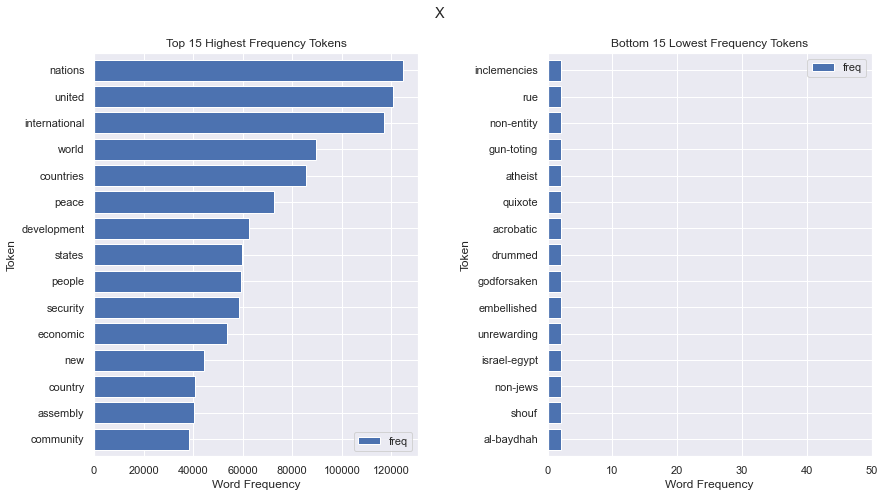

In [114]:
fig, ax = plt.subplots(1, 2, figsize=(12,8))
fig.suptitle("X")

# set first ax
freq_df.head(15).plot(kind='barh', width=0.8, ax=ax[0])

# invert to put top freq words at the top 
ax[0].invert_yaxis()

# set labels
ax[0].set(xlabel='Word Frequency', ylabel='Token', title='Top 15 Highest Frequency Tokens')

### plot 2nd ax ### 
freq_df.tail(15).plot(kind='barh', width=0.8, ax=ax[1])

# invert to put top freq words at the top 
ax[1].invert_yaxis()

# need to manually adjust xlim for the two graphs to be visually interpretable 
ax[1].set_xlim(0, 50) 

# set labels
ax[1].set(xlabel='Word Frequency', ylabel='Token', title='Bottom 15 Lowest Frequency Tokens')

# adjust subplots spacing
plt.subplots_adjust(left=0.1,
                    bottom=0.2, 
                    right=1, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)

plt.show();

## MORE FILTERED VISUAL ANALYSIS 
* E.G. include year, country etc.
* Try using a more visually satisfying tool in NLP called "wordclouds" 

In [32]:
## a simple starting point for a small amount of text
# lets use italy for an example 
df.query('year==2015 and country=="ITA"')

,session,year,country,country_name,speaker,position,text,length,tokens,len_tokens
7397,70,2015,ITA,Italy,Mr. Matteo Renzi,Prime minister,It is with gratitude and pride that I come her...,14686,"[gratitude, pride, come, today, express, voice...",1231


In [29]:
# set a sample text of italy's speech from 2015, use their "tokens" (already cleaned tokens from the text)
sample_text = df.query('year==2015 and country=="ITA"')['tokens'].values[0]

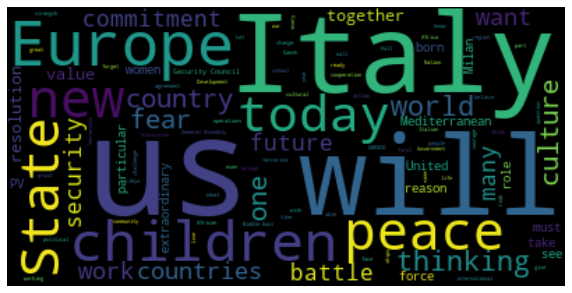

In [35]:
plt.figure(figsize=(10, 10)) 

# wordcloud object, pass in stopwords as we used "text" so 
wc = WordCloud(max_words=100) ##note tokens have already had their stopwords removed 
## else can use stopwords=stopwords if text

# apply to sample text 
wc.generate(sample_text)
plt.imshow(wc, interpolation='bilinear')
plt.axis("off");

* A generally interesting start, unsurprisingly italy mentions itself and Europe alot
    * But if we want to generalise or summarise every speech for the entire conference? 


* However, for large amounts of data, faster to generate a frequency counter and then use the function `generate_from_frequencies()`


* Define a general function which takes our `freq_df` from our function `counter_word_function` 
    * It might also be useful to add a custom stopwords addition to filter out unevitable formalities (E.G. the word "united nations") as it will appear every year and be relatively meaningless in the context 
        * could also use the top (X) counted-words as stopwords for the wordclouds and see if the results improve 

In [22]:
def custom_wordcloud(word_freq, max_words=150, title=None, stopwords=None):

    # initialise wordcloud object with some styling parameters + pass in desired max_words 
    wc = WordCloud(width=800, height=400, 
                   background_color= "black", colormap="Paired", 
                   max_font_size=150, max_words=max_words)
    
    # convert data frame into dict
    if type(word_freq) == pd.Series:
        counter = Counter(word_freq.fillna(0).to_dict()) # fill NaN with 0 
    else:
        counter = word_freq

    # filter stop words in frequency counter
    if stopwords is not None:
        counter = {token:freq for (token, freq) in counter.items() 
                              if token not in stopwords}
        
    # use wordcloud's generate from frequencies function (from our pre-made frequenc counter dict)
    wc.generate_from_frequencies(counter)
 
    # set title & show 
    plt.title(title) 
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")

In [47]:
freq_2015_df

,freq
token,
nations,2587
united,2571
development,1754
international,1727
world,1635
...,...
guatemalans,2
destroys,2
displaces,2


progress-bar: 100%|████████████████████████████████████████████████████████████████| 193/193 [00:00<00:00, 9700.31it/s]


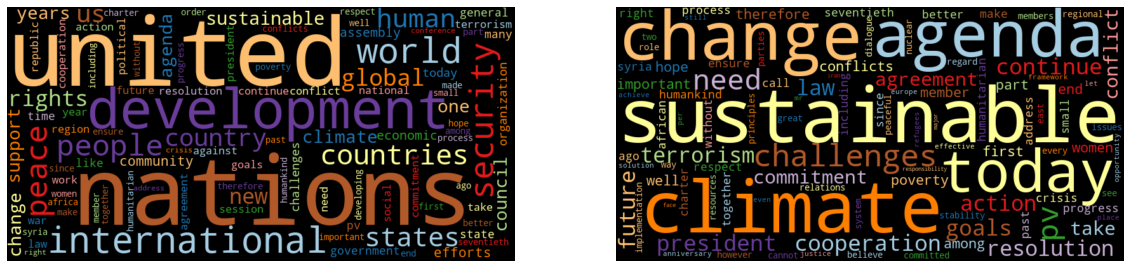

In [57]:
# define a DF of word-frequencies for year=2015
freq_2015_df = counter_word_function(df[df['year']==2015])

# specify subplots layout and figsize
plt.figure(figsize=(20,15))
plt.subplot(1,2,1)
plt.title("WC without stopwords")

# use customwordcloud function
custom_wordcloud(freq_2015_df['freq'], max_words=100)

# pass in stopwords from top frequency from aggregate freq_df (not 2015 version)
plt.subplot(1,2,2)
plt.title("WC with stopwords")
custom_wordcloud(freq_2015_df['freq'], max_words=100, stopwords=freq_df.head(50).index)

* Obviously, the one with top freq words filtered out gives a better impression of the uniqueness of 2015
    * instead of united nations, development etc. 
    * It can be seen the agenda had a focus on climate/environment, a few mentions of terrorism, conflict etc. 
    

* Still, the there are a multitude of very obvious domain-based words which don't convey a lot of special meaning about this particular slice of the data VS. other UN speeches (e.g. change, challenges, today) etc. 
    * we can give these words less weight by using a TD-IDF method in the next section

In [58]:
## try fixing with subplots(plot, ax(1)) etc. to get figsize adjusted properly 

## ITERATE FURTHER WITH TF-IDF WEIGHTING 
* Give less weight to words which occur frequently in aby subset/slice of the data (E.G. all UN speeches)
    * that is to say, reduce the impact of common terms on the data analysis 
* Inversely, giving more weight/importance to words which ocur more frequently in a particular subset of data then "usual" (AKA higher than what their total probability would suggest) - in a sense, measuring the "surprise" or "unusualness" factor of the frequency for a word to appear more in a subset

In [5]:
# define an IDF function which takes the pre-processed col of text called "tokens" 
## min word freq is again (2) and optional pass-in for new text processing pipeline

def compute_idf(df, column='tokens', preprocess=None, min_df=2):

    def update(doc):
        tokens = doc if preprocess is None else preprocess(doc)
        counter.update(set(tokens))

    # counter objectt 
    counter = Counter()
    df[column].progress_map(update)

    # create data frame to store computed idf
    idf_df = pd.DataFrame.from_dict(counter, orient='index', columns=['df'])
    idf_df = idf_df.query('df >= @min_df')
    
    ## IDF formula 
    ## the idf(t) score = 0 for terms that appear in all documents; to not completely remove these words from analysis:
    ## we add +0.1 constant term (roughly equal to 90% of the documents); that is: log(1/0.9) != 0 
    idf_df['idf'] = np.log(len(df) / idf_df['df'])+0.1
    idf_df.index.name = 'token'
    
    return idf_df

In [6]:
# define idf DF
idf_df = compute_idf(df)

progress-bar: 100%|██████████████████████████████████████████████████████████████| 7507/7507 [00:01<00:00, 4453.27it/s]
C:\Users\jason\AppData\Local\Temp/ipykernel_304/3967337431.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  idf_df['idf'] = np.log(len(df) / idf_df['df'])+0.1


In [8]:
# E.G. (note: this is not tf-idf yet)
# terms appearing in many documments have a high document frequency
# but in IDF - high IDF means a rarer term (hence air/borne is rarer than the word affairs)
idf_df.head()

,df,idf
token,,
affairs,3893,0.756656
even,4983,0.509804
wars,1854,1.498490
borne,475,2.860276
air,740,2.416941


In [15]:
# combine with our IDF_DF with freq_DF to obtain: TF-IDF (works as both share an index of tokens)

## join first then multiply for faster results
freq_df = freq_df.join(idf_df)

# multiply freq and idf
freq_df['tf_idf'] = freq_df['freq'] * freq_df['idf']

In [16]:
# E.G. 
# tf-idf yields a high score for terms appearing frequrntly 
freq_df.head()

,freq,df,idf,tf_idf
token,,,,
nations,124508,7495.0,0.101600,12649.986284
united,120763,7494.0,0.101733,12285.608632
international,117223,7466.0,0.105477,12364.276226
world,89421,7460.0,0.106281,9503.708982
countries,85734,7307.0,0.127003,10888.485986


In [19]:
# we can view the bottom scores
freq_df.sort_values(by=['tf_idf'], ascending=True).head(5)

,freq,df,idf,tf_idf
token,,,,
shouf,2,2.0,8.330444,16.660888
trouble-stricken,2,2.0,8.330444,16.660888
dis-quieting,2,2.0,8.330444,16.660888
gloomily,2,2.0,8.330444,16.660888
straightaway,2,2.0,8.330444,16.660888


## RE-ITERATE WORD-CLOUD WITH TF-IDF WEIGHTING 
* Compare the results for new and old iteration in 2015
* Compare 1970 topics vs. 2015 topics 

In [23]:
# define specific DF for each respective year
## use the earlier defined function again to generate the freq_df for the respective year 
freq_1970 = counter_word_function(df[df['year'] == 1970])
freq_2015 = counter_word_function(df[df['year'] == 2015])

freq_1970['tfidf'] = freq_1970['freq'] * idf_df['idf']
freq_2015['tfidf'] = freq_2015['freq'] * idf_df['idf']

progress-bar: 100%|████████████████████████████████████████████████████████████████| 193/193 [00:00<00:00, 8252.80it/s]


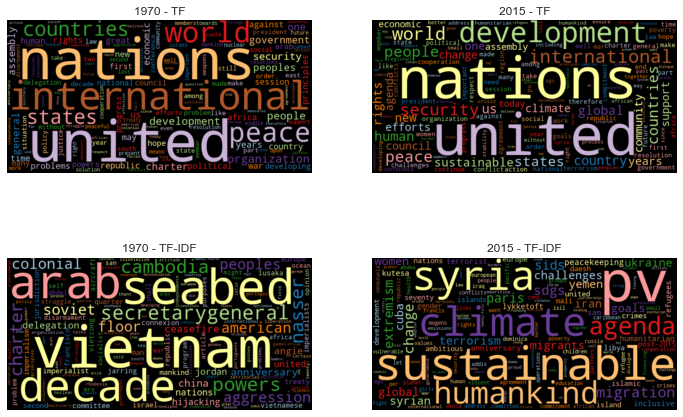

In [26]:
# once again, call our custom wordcloud function: custom_wordcloud

# set fig size 
plt.figure(figsize=(12,8))

## call custom wc function on the 4 iterations:
# the freq for 1970/2015 and then again the tf-idf for both years and compare results:
# add a custom stopword for each respective year of that year's UN meeting value (obviously a high freq term)
plt.subplot(2,2,1)
custom_wordcloud(freq_1970['freq'], title='1970 - TF', 
          stopwords=['twenty-fifth', 'twenty-five'])

plt.subplot(2,2,2)
custom_wordcloud(freq_2015['freq'], title='2015 - TF', 
          stopwords=['seventieth'])

plt.subplot(2,2,3)
custom_wordcloud(freq_1970['tfidf'], title='1970 - TF-IDF', 
          stopwords=['twenty-fifth', 'twenty-five', 'twenty', 'fifth'])

plt.subplot(2,2,4)
custom_wordcloud(freq_2015['tfidf'], title='2015 - TF-IDF', 
          stopwords=['seventieth'])

* There is a marked difference between 1970-2015 for the TF-IDF versions
    * The TF only versions generally look the same, representing fairly meaningless formalities that are mentioend every eyar
* We can see some interesting specific terms for either year
    * E.G. "nasser", "sdgs", "sids"
    * Or what might be interesting in 2022's current climate, see what was mentioned about Ukraine specifically in 2015

## KEYWORD IN CONTEXT ANALYSIS (KWIC) 
* uses `textacy` package

In [4]:
# conda install -c conda-forge textacy
# import textacy
from textacy.extract.kwic import keyword_in_context

In [5]:
def KWIC(*args, **kwargs):
    # call keyword_in_context with all params except 'print_only'
    ## this will be passed into a generalised function for spanning multipe docs 
    return keyword_in_context(*args, 
                       # unpack the optional args passed in if print_only is not set to True 
                       **{kw: arg for kw, arg in kwargs.items() if kw != 'print_only'})

In [12]:
def kwic(doc_series, keyword, window=50, print_samples=5):

    # initialise empty list
    kwic_list = []
    
    # extend (append to the end) of the initialised list (the pre-keyword items, keyword, post-keyword items)
    ## in line with the desired window size (default = 50)
    def add_kwic(text):
        kwic_list.extend(KWIC(text, keyword, ignore_case=True, 
                              window_width=window, print_only=False))

    ## call tqdm's map version
    doc_series.progress_map(add_kwic)

    # if print is not specified, return list instead
    if print_samples is None or print_samples==0:
        return kwic_list
    else:
        k = min(print_samples, len(kwic_list))
        # print number of samples being printed from the total 
        print(f"{k} random samples out of {len(kwic_list)} " + \
              f"contexts for '{keyword}':")
        # print random sample from among specified number of items to print 
        for sample in random.sample(list(kwic_list), k):
            print(re.sub(r'[\n\t]', ' ', sample[0])+'  '+ \
                  sample[1]+'  '+\
                  re.sub(r'[\n\t]', ' ', sample[2]))

In [13]:
# set random seed
random.seed(1)

# see keywords in context for 2015 and "ukraine"; change print_samples to 10 
kwic(df[df['year'] == 2015]['text'], 'ukraine', print_samples=10)

progress-bar: 100%|████████████████████████████████████████████████████████████████| 193/193 [00:00<00:00, 7730.73it/s]

10 random samples out of 98 contexts for 'ukraine':
pointing that in cases such as those of Syria and   Ukraine  , Council debates have brought no result. Council 
ng to the implementation of the Minsk agreements.   Ukraine   is committed to following the letter and spirit o
nity’s attention. Nor can the tragic situation in   Ukraine   be overlooked or many other smaller or more conta
perpetrated in Syria, Palestine, Israel, Nigeria,   Ukraine   and beyond. This condition brings me back to the 
 international order. The occupied territories of   Ukraine  , Georgia or Moldova are full of red lines that we
 but also to put an end to the aggression against   Ukraine  . Compared to what it was a year ago, the armed co
of the Russian-backed terrorists and occupiers in   Ukraine   and Donbas. More than 1.5 million residents of Do
 and principles of that Charter. The statement by   Ukraine   upon its joining the United Nations as one of its
f Ukraine. That country used to be a guarantor of   

* Let's focus on that last sentence - perhaps see which country said it 

In [16]:
# pass in print_samples = 0 to supress print and return list (as per textacy doc, func returns list)
ukraine_2015_list = kwic(df[df['year'] == 2015]['text'], 'ukraine', print_samples=0, 
                        window=100)

progress-bar: 100%|████████████████████████████████████████████████████████████████| 193/193 [00:00<00:00, 7167.21it/s]


In [17]:
# print sentence in question  
ukraine_2015_list[10]

('s well as the abuses that follow in the wake of acts of aggression, such as the Russian invasion of ',
 'Ukraine',
 ', the illegal annexation of Crimea and the continued interference in eastern Ukraine. This rostrum m')

In [110]:
# sample_statement = ukraine_2015_list[10]
# sample_statement = str(ukraine_2015_list[10])[-50:]

In [84]:
# token_sample_statement = prepare_text(str(sample_statement), pipeline=pipeline)
# df.loc[df['tokens'].str.contains(str(token_sample_statement), case=False)]

# spits error 

In [95]:
# we can see this particular substring was mentioned by Canada in 2015
df.loc[df['text'].str.contains(str(sample_statement[-10:]), regex=False, 
                               case=False)]

,session,year,country,country_name,speaker,position,text,length,tokens,len_tokens


In [27]:
# we can see this particular substring was mentioned by Canada in 2015
df.loc[df['text'].str.contains("the illegal annexation of Crimea and the continued interference in eastern Ukraine",
                               case=False)]

,session,year,country,country_name,speaker,position,text,length,tokens,len_tokens
7343,70,2015,CAN,Canada,Mr. Daniel Jean,Deputy Minister Foreign Affairs,I am honoured to appear before the Assembly to...,14323,"[honoured, appear, assembly, today, deliver, r...",1212


## BI-GRAMS
* How to overcome the issue of confusing context with words such as "climate" E.G. "climate change" vs "political climate" vs "climate (environmentally) " vs "change climate" etc. 
* Also, how to handle compounds (combination of 2 or more word with a singular meaning in English, for instance "climate change" refers to a single specific meaning, as does something like "self-confident" etc. 
* Additionally, collocations are words which frequently used together to mean something possibly different then what their individual units would suggest, E.G. "united nations" , "red carpet" 



#### BI-GRAMS creation process:
* to avoid having bigrams with stopwords (prepositions etc.) - we should build bi-grams without stop words; but if remove them first and then build a bi-gram, we will generate bi-grams which don't actually exist in the real text. 
* Thus, create the bi-grams on all tokens but only keep those that do not contain any stopwords 

In [111]:
def ngrams(tokens, n=2, sep=' ', stopwords=set()):
    """
    function for i in the range of (2) bigrams, to join these two items with a ' ' whitespace
    If the len (aka number of stopwords) in the bigram is equal to 0 
    apply to new DF col with apply 
    """
    return [sep.join(ngram) for ngram in zip(*[tokens[i:] for i in range(n)])
            if len([t for t in ngram if t in stopwords])==0]

In [119]:
# create new DF col with bi-grams 
df['bigrams'] = df['text'].progress_apply(prepare_text, pipeline=[str.lower, tokenize_lowercase]) \
                          .progress_apply(ngrams, n=2, stopwords=stopwords)


progress-bar: 100%|███████████████████████████████████████████████████████████████| 7507/7507 [00:09<00:00, 815.35it/s]


In [117]:
## can also just apply straight from tokens 
# df['bigrams'] = df['tokens'].progress_apply(ngrams, n=2, stopwords=stopwords)

progress-bar: 100%|██████████████████████████████████████████████████████████████| 7507/7507 [00:05<00:00, 1252.86it/s]


In [120]:
# E.G. 
df.bigrams.iloc[0][:10]

['first convey',
 'albanian delegation',
 'twenty-fifth session',
 'general assembly',
 'twenty- fifth',
 'fifth session',
 'general assembly',
 'twenty-fifth anniversary',
 'united nations',
 'peace-loving member']

In [127]:
# top bi-grams
## not many surprises 
counter_word_function(df, 'bigrams').head(10)

progress-bar: 100%|██████████████████████████████████████████████████████████████| 7507/7507 [00:01<00:00, 7436.43it/s]


,freq
token,
united nations,103236
international community,27786
general assembly,27096
security council,20961
human rights,19856
developing countries,18511
united states,12363
middle east,12121
south africa,11105


In [ ]:
## try re-computing word-cloud with bi-grams 
